In [1]:
import os
import sys

sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

import hydra
import numpy as np
import pytorch_lightning as pl
import torch
from omegaconf import OmegaConf

# set env variable DATA_DIR again because of hydra
from dotenv import load_dotenv

load_dotenv()
os.environ["DATA_DIR"] = os.environ.get("DATA_DIR")

# plots and metrics
import matplotlib.pyplot as plt

from src.data.components import calculate_all_wasserstein_metrics
from src.utils.data_generation import generate_data
from src.utils.plotting import apply_mpl_styles, create_and_plot_data, plot_single_jets

apply_mpl_styles()

In [2]:
experiment = "fm_tops_slurm.yaml"
model_name_for_saving = "nb_fm_tops30"

# load everything from experiment config
with hydra.initialize(version_base=None, config_path="../configs/"):
    cfg = hydra.compose(config_name="train.yaml", overrides=[f"experiment={experiment}"])
    print(OmegaConf.to_yaml(cfg))

datamodule = hydra.utils.instantiate(cfg.data)
model = hydra.utils.instantiate(cfg.model)
datamodule.setup()

task_name: fm_tops-${model.num_particles}
tags:
- flow_matching
- tops
train: true
test: true
ckpt_path: null
seed: 12345
data:
  _target_: src.data.jetnet_datamodule.JetNetDataModule
  data_dir: ${paths.data_dir}
  batch_size: 1024
  num_workers: 32
  pin_memory: false
  val_fraction: 0.15
  test_fraction: 0.15
  jet_type:
  - t
  num_particles: ${model.num_particles}
  variable_jet_sizes: ${model.mask}
  centering: true
  normalize: true
  use_calculated_base_distribution: false
  normalize_sigma: 5
  conditioning_type: false
  conditioning_pt: true
  conditioning_eta: false
  conditioning_mass: true
  conditioning_num_particles: false
model:
  _target_: src.models.flow_matching_module.SetFlowMatchingLitModule
  optimizer:
    _target_: torch.optim.AdamW
    _partial_: true
    lr: 0.001
    weight_decay: 5.0e-05
  scheduler:
    _target_: src.schedulers.lr_scheduler.CosineWarmupScheduler
    _partial_: true
    warmup: ${trainer.min_epochs}
    max_iters: ${trainer.max_epochs}
  opt

/home/birkjosc/repositories/EPiC-FM/notebooks/../src/models/flow_matching_module.py:408: UserWarning: Optimizer for discriminator is not None but loss comparison is not adversarial!
  warnings.warn(
/home/birkjosc/repositories/EPiC-FM/notebooks/../src/models/flow_matching_module.py:416: UserWarning: Loss type for discriminator is not None but loss comparison is not adversarial!
  warnings.warn(


In [4]:
test_data = np.array(datamodule.tensor_test)
test_mask = np.array(datamodule.mask_test)
test_cond = np.array(datamodule.tensor_conditioning_test)
val_data = np.array(datamodule.tensor_val)
val_mask = np.array(datamodule.mask_val)
val_cond = np.array(datamodule.tensor_conditioning_val)
train_data = np.array(datamodule.tensor_train)
train_mask = np.array(datamodule.mask_train)
train_cond = np.array(datamodule.tensor_conditioning_train)
means = np.array(datamodule.means)
stds = np.array(datamodule.stds)

print(test_data.shape)
print(test_mask.shape)
print(test_cond.shape)
print(val_data.shape)
print(val_mask.shape)
print(val_cond.shape)
print(train_data.shape)
print(train_mask.shape)
print(train_cond.shape)
print(means)
print(stds)

(26691, 30, 3)
(26691, 30, 1)
(26691, 2)
(26691, 30, 3)
(26691, 30, 1)
(26691, 2)
(124563, 30, 3)
(124563, 30, 1)
(124563, 2)
[-3.10665230e-05 -6.85678050e-05  3.05046788e-02]
[0.11627382 0.11724178 0.03943919]


In [5]:
ckpt = "/beegfs/desy/user/birkjosc/epic-cnf/logs/fm_tops-30/runs/2023-06-23_14-03-53/checkpoints/epoch_3979_w1m_0.00029529-EMA.ckpt"
model = model.load_from_checkpoint(ckpt)

/home/birkjosc/repositories/EPiC-FM/notebooks/../src/models/flow_matching_module.py:408: UserWarning: Optimizer for discriminator is not None but loss comparison is not adversarial!
  warnings.warn(
/home/birkjosc/repositories/EPiC-FM/notebooks/../src/models/flow_matching_module.py:416: UserWarning: Loss type for discriminator is not None but loss comparison is not adversarial!
  warnings.warn(


In [26]:
factor = 6
# chosse between test and val
mask_gen = test_mask
data_gen = test_data
cond_gen = test_cond

# increase size for better statistics
big_mask = np.repeat(mask_gen, factor, axis=0)
big_data = np.repeat(data_gen, factor, axis=0)
big_cond = np.repeat(cond_gen, factor, axis=0)

In [27]:
data, generation_time = generate_data(
    model,
    num_jet_samples=factor * len(mask_gen),
    batch_size=1000,
    cond=torch.tensor(big_cond),
    variable_set_sizes=True,
    mask=torch.tensor(big_mask),
    normalized_data=True,
    means=means,
    stds=stds,
    ode_solver="midpoint",
    ode_steps=200,
)

Generating data. Device: cuda


  0%|          | 0/160 [00:00<?, ?it/s]

100%|██████████| 160/160 [08:44<00:00,  3.28s/it]


In [29]:
particle_data = data
w_dists_big = calculate_all_wasserstein_metrics(
    data_gen[..., :3],
    particle_data[..., :3],
    None,
    None,
    num_eval_samples=len(data_gen),
    num_batches=factor,
    calculate_efps=True,
    use_masks=False,
)

print(f"W-Dist m: {w_dists_big['w1m_mean']:4.3E} +- {w_dists_big['w1m_std']:4.3E}")
print(f"W-Dist p: {w_dists_big['w1p_mean']:4.3E} +- {w_dists_big['w1p_std']:4.3E}")
print(f"W-Dist efp: {w_dists_big['w1efp_mean']:4.3E} +- {w_dists_big['w1efp_std']:4.3E}")

W-Dist m: 4.339E-04 +- 6.578E-05
W-Dist p: 3.462E-04 +- 1.521E-04
W-Dist efp: 8.713E-06 +- 4.508E-06


In [33]:
w_dists_big_non_averaged = calculate_all_wasserstein_metrics(
    data_gen[..., :3],
    particle_data[..., :3],
    None,
    None,
    num_eval_samples=len(data_gen),
    num_batches=factor,
    calculate_efps=True,
    use_masks=False,
)
w_dists_big_non_averaged

{'w1m_mean': 0.0004288157915944869,
 'w1p_mean': array([0.0004748 , 0.00037017, 0.00014523]),
 'w1efp_mean': 7.99808299267694e-06,
 'w1m_std': 0.00010445316825566728,
 'w1p_std': array([9.51830315e-05, 5.46011812e-05, 3.36996889e-05]),
 'w1efp_std': 3.0095359881262687e-06}

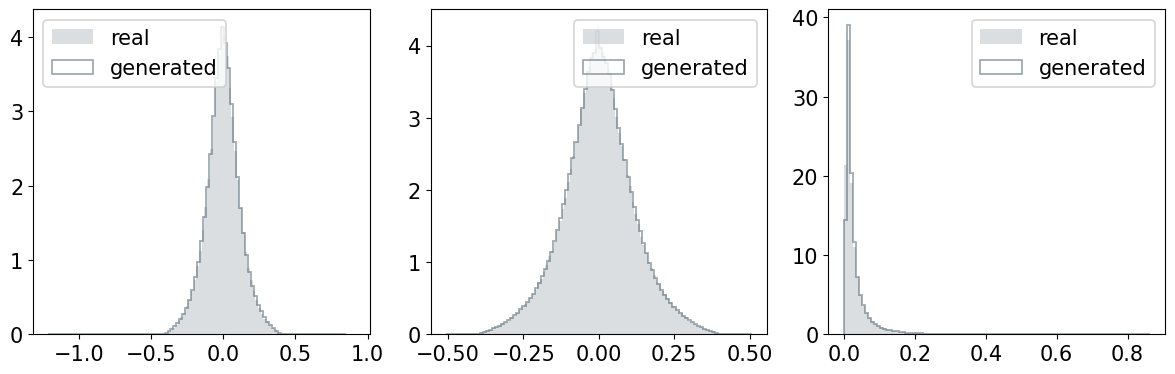

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()
hist_kwargs = dict(bins=100, alpha=0.5, density=True)
for i in range(3):
    ax[i].hist(data_gen[:, :, i].flatten(), **hist_kwargs, label="real")
    ax[i].hist(particle_data[:, :, i].flatten(), **hist_kwargs, label="generated", histtype="step")
    ax[i].legend()
fig.tight_layout()